## O Objetivo
Realizar um modelo preditivo com base na serie temporal do IBOVESPA e prever os dados de fechamento

## Importanto as Bibliotecas

In [1]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.5 MB/s eta 0:00:00


In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from prophet import Prophet

## Importando a base de dados IBOVESPA
Os dados foram obtidos através do site https://br.investing.com/indices/bovespa-historical-data considerando as data de 2020 a 2024 (Junho)

In [375]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa 2020-2024.csv')
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.06.2024,123.907,124.308,124.500,123.298,"9,07B","-0,32%"
1,27.06.2024,124.308,122.642,124.308,122.642,"8,71B","1,36%"
2,26.06.2024,122.641,122.331,122.701,121.402,"8,18B","0,25%"


In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      1118 non-null   object 
 1   Último    1118 non-null   float64
 2   Abertura  1118 non-null   float64
 3   Máxima    1118 non-null   float64
 4   Mínima    1118 non-null   float64
 5   Vol.      1118 non-null   object 
 6   Var%      1118 non-null   object 
dtypes: float64(4), object(3)
memory usage: 61.3+ KB


## Tratamento de dados

In [377]:
# Para saber se tem dados nulos
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [378]:
# Converter a coluna "Data" para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-06-28,123.907,124.308,124.500,123.298,"9,07B","-0,32%"
1,2024-06-27,124.308,122.642,124.308,122.642,"8,71B","1,36%"
2,2024-06-26,122.641,122.331,122.701,121.402,"8,18B","0,25%"


In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      1118 non-null   datetime64[ns]
 1   Último    1118 non-null   float64       
 2   Abertura  1118 non-null   float64       
 3   Máxima    1118 non-null   float64       
 4   Mínima    1118 non-null   float64       
 5   Vol.      1118 non-null   object        
 6   Var%      1118 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 61.3+ KB


In [380]:
# Ordenar por data
df = df.sort_values('Data')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1117,2020-01-02,118.573,115.652,118.573,115.649,"5,16M","2,53%"
1116,2020-01-03,117.707,118.564,118.792,117.341,"6,83M","-0,73%"
1115,2020-01-06,116.878,117.707,117.707,116.269,"6,57M","-0,70%"
1114,2020-01-07,116.662,116.872,117.076,115.965,"4,85M","-0,18%"
1113,2020-01-08,116.247,116.667,117.335,115.693,"5,91M","-0,36%"


In [381]:
# Função para converter "Vol." para valores numéricos
def convert_volume(vol):
    if 'M' in vol:
        return float(vol.replace('M', '').replace(',', '.')) * 1_000_000
    elif 'B' in vol:
        return float(vol.replace('B', '').replace(',', '.')) * 1_000_000_000
    else:
        return float(vol.replace(',', '.'))

In [382]:
# Aplicar a função na coluna "Vol."
df['Vol.'] = df['Vol.'].apply(convert_volume)
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1117,2020-01-02,118.573,115.652,118.573,115.649,5160000.0,"2,53%"
1116,2020-01-03,117.707,118.564,118.792,117.341,6830000.0,"-0,73%"
1115,2020-01-06,116.878,117.707,117.707,116.269,6570000.0,"-0,70%"


In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118 entries, 1117 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      1118 non-null   datetime64[ns]
 1   Último    1118 non-null   float64       
 2   Abertura  1118 non-null   float64       
 3   Máxima    1118 non-null   float64       
 4   Mínima    1118 non-null   float64       
 5   Vol.      1118 non-null   float64       
 6   Var%      1118 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 69.9+ KB


In [384]:
# Remover a coluna "Var%"
df = df.drop(columns=['Var%'])
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.
1117,2020-01-02,118.573,115.652,118.573,115.649,5160000.0
1116,2020-01-03,117.707,118.564,118.792,117.341,6830000.0
1115,2020-01-06,116.878,117.707,117.707,116.269,6570000.0


In [385]:
#Separando df para o Prophet
df_p = df
df_p.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.
1117,2020-01-02,118.573,115.652,118.573,115.649,5160000.0
1116,2020-01-03,117.707,118.564,118.792,117.341,6830000.0
1115,2020-01-06,116.878,117.707,117.707,116.269,6570000.0
1114,2020-01-07,116.662,116.872,117.076,115.965,4850000.0
1113,2020-01-08,116.247,116.667,117.335,115.693,5910000.0


## Visualização dos Dados

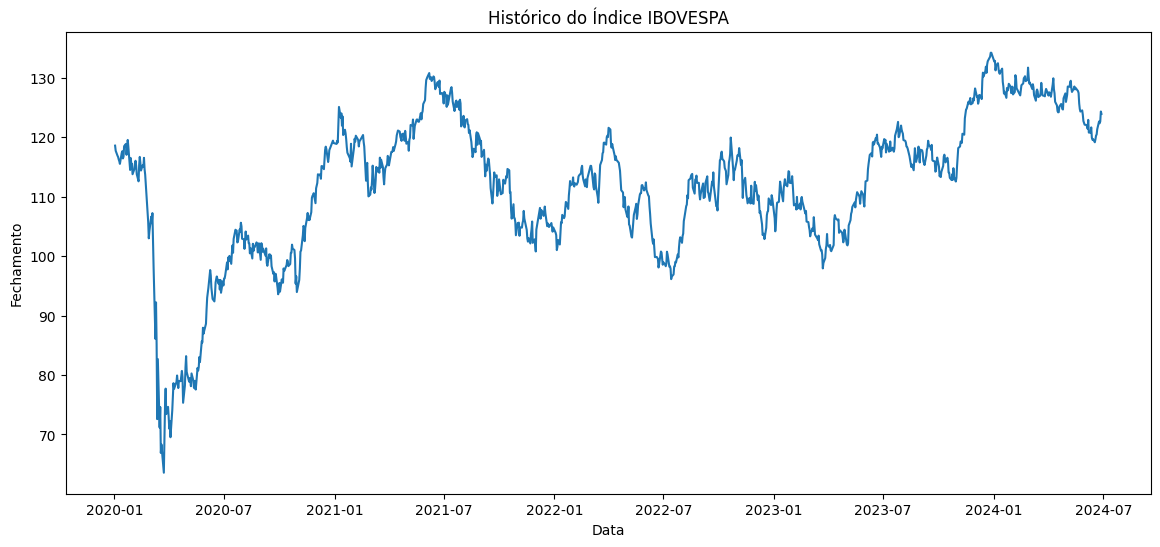

In [386]:
# Plotando a série temporal

plt.figure(figsize=(14, 6))
plt.plot(df['Data'], df['Último'])
plt.title('Histórico do Índice IBOVESPA')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.grid(False)
plt.show()

## Decomposição da Série Temporal

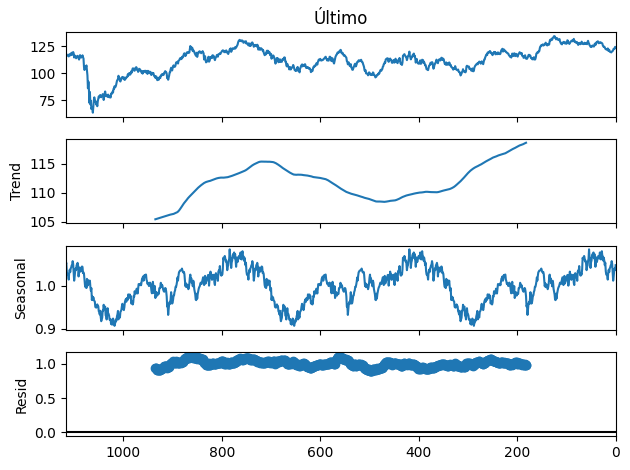

In [387]:
# Decomposição da série temporal

result = seasonal_decompose(df["Último"], model="multiplicative", period=365)
result.plot()
plt.show()

## Verificação de Estacionariedade

In [388]:
# Verificação de Estacionariedade

from statsmodels.tsa.stattools import adfuller

# Função para verificar estacionariedade
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}: {value}')

test_stationarity(df['Último'])

ADF Statistic: -2.390926
p-value: 0.144314
Critical Values:
   1%: -3.4362549432361504
Critical Values:
   5%: -2.8641473395601595
Critical Values:
   10%: -2.568158225793361


## Aplicando Diferenciação

In [389]:
# Diferenciação

df['Último_diff'] = df['Último'].diff().dropna()
test_stationarity(df['Último_diff'].dropna())

ADF Statistic: -11.069135
p-value: 0.000000
Critical Values:
   1%: -3.4362549432361504
Critical Values:
   5%: -2.8641473395601595
Critical Values:
   10%: -2.568158225793361


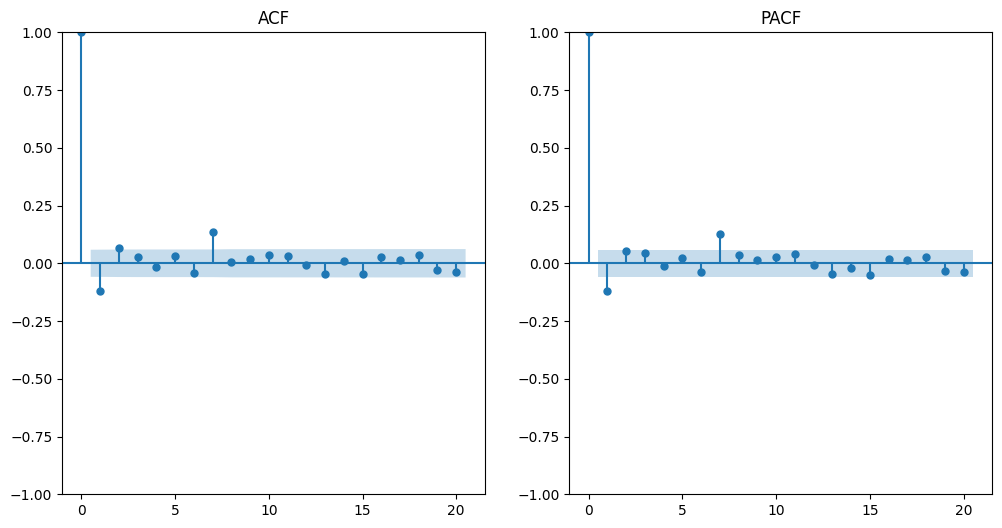

In [390]:
# Identificação dos Parâmetros

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Último_diff'].dropna(), lags=20, ax=plt.gca())
plt.title('ACF')
plt.subplot(122)
plot_pacf(df['Último_diff'].dropna(), lags=20, ax=plt.gca())
plt.title('PACF')
plt.show()

## Métricas de Avaliação do Modelo

In [391]:
# Funções de Avaliação

def wmape(y_true, y_pred):
   return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

def calculate_smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## Preparar o DataFrame e separar as bases de treino e teste (Naive e AutoArima)

In [392]:
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Último_diff
1117,2020-01-02,118.573,115.652,118.573,115.649,5160000.0,NaN
1116,2020-01-03,117.707,118.564,118.792,117.341,6830000.0,-0.866
1115,2020-01-06,116.878,117.707,117.707,116.269,6570000.0,-0.829


In [393]:
# Acrescentando a coluna 'unique id'
df['unique_id'] = 'IBOVESPA'
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Último_diff,unique_id
1117,2020-01-02,118.573,115.652,118.573,115.649,5160000.0,NaN,IBOVESPA
1116,2020-01-03,117.707,118.564,118.792,117.341,6830000.0,-0.866,IBOVESPA
1115,2020-01-06,116.878,117.707,117.707,116.269,6570000.0,-0.829,IBOVESPA


In [394]:
df = df[["Data", "Último", "unique_id"]]
df.head(3)

,Data,Último,unique_id
1117,2020-01-02,118.573,IBOVESPA
1116,2020-01-03,117.707,IBOVESPA
1115,2020-01-06,116.878,IBOVESPA


In [395]:
df = df.rename(columns={'Data':'ds','Último':'y'})
df.head(3)

,ds,y,unique_id
1117,2020-01-02,118.573,IBOVESPA
1116,2020-01-03,117.707,IBOVESPA
1115,2020-01-06,116.878,IBOVESPA


In [396]:
#Ordenando as colunas

df = df[['ds', 'unique_id', 'y']]
df.head(3)

,ds,unique_id,y
1117,2020-01-02,IBOVESPA,118.573
1116,2020-01-03,IBOVESPA,117.707
1115,2020-01-06,IBOVESPA,116.878


In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118 entries, 1117 to 0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         1118 non-null   datetime64[ns]
 1   unique_id  1118 non-null   object        
 2   y          1118 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 34.9+ KB


In [398]:
# Filtrar base de treino entre Jan 2020 até Dez de 2023
train = df.loc[df['ds'] < '2024-01-01']

# Filtrar base de teste entre Jan 2024 até Jun de 2024
valid = df.loc[(df['ds'] >= '2024-01-01') & (df['ds'] < '2024-07-01')]

h = valid['ds'].nunique()

In [399]:
h

124

## Modelo Naive

In [400]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train)

forecast_df = model.predict(h=h, level=[80])
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_df.head()

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,Naive,Naive-lo-80,Naive-hi-80,y
0,IBOVESPA,2023-12-29,134.184998,131.984711,136.385284,NaN
1,IBOVESPA,2023-12-30,134.184998,131.073318,137.296677,NaN
2,IBOVESPA,2023-12-31,134.184998,130.373993,137.996002,NaN
3,IBOVESPA,2024-01-01,134.184998,129.784424,138.585571,NaN
4,IBOVESPA,2024-01-02,134.184998,129.265015,139.104980,132.697


In [401]:
forecast_df = forecast_df.dropna()
forecast_df.head()

,unique_id,ds,Naive,Naive-lo-80,Naive-hi-80,y
4,IBOVESPA,2024-01-02,134.184998,129.265015,139.104980,132.697
5,IBOVESPA,2024-01-03,134.184998,128.795425,139.574570,132.834
6,IBOVESPA,2024-01-04,134.184998,128.363586,140.006409,131.226
7,IBOVESPA,2024-01-05,134.184998,127.961647,140.408340,132.023
10,IBOVESPA,2024-01-08,134.184998,126.887474,141.482529,132.427


WMAPE: 4.68%


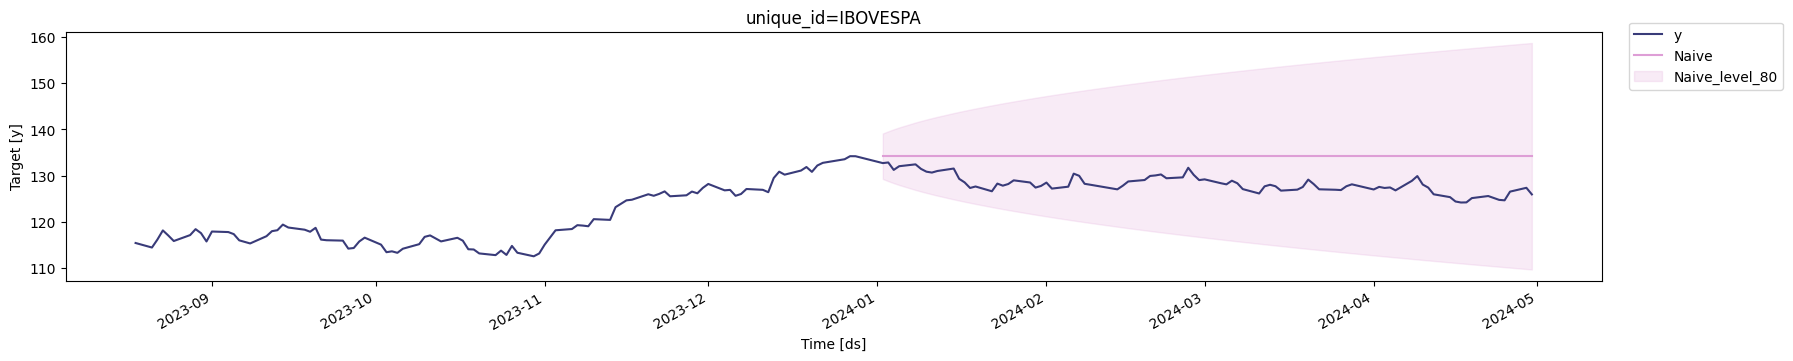

In [402]:
wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

model.plot(train, forecast_df, level=[80],engine ='matplotlib', max_insample_length=90)

## Plotando Previsão vs Real (Naive)

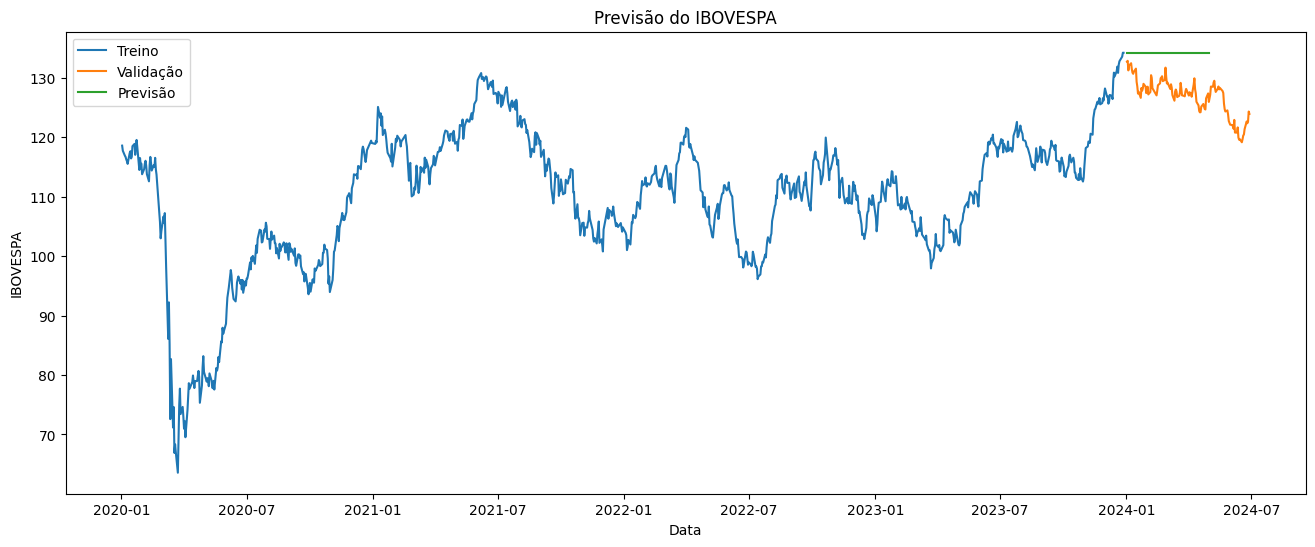

In [403]:
plt.figure(figsize=(16, 6))
plt.plot(train['ds'], train['y'], label='Treino')
plt.plot(valid['ds'], valid['y'], label='Validação')
plt.plot(forecast_df['ds'], forecast_df['Naive'], label='Previsão')
plt.xlabel('Data')
plt.ylabel('IBOVESPA')
plt.title('Previsão do IBOVESPA')
plt.legend()
plt.show()

## Modelo AutoArima

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 4.98%


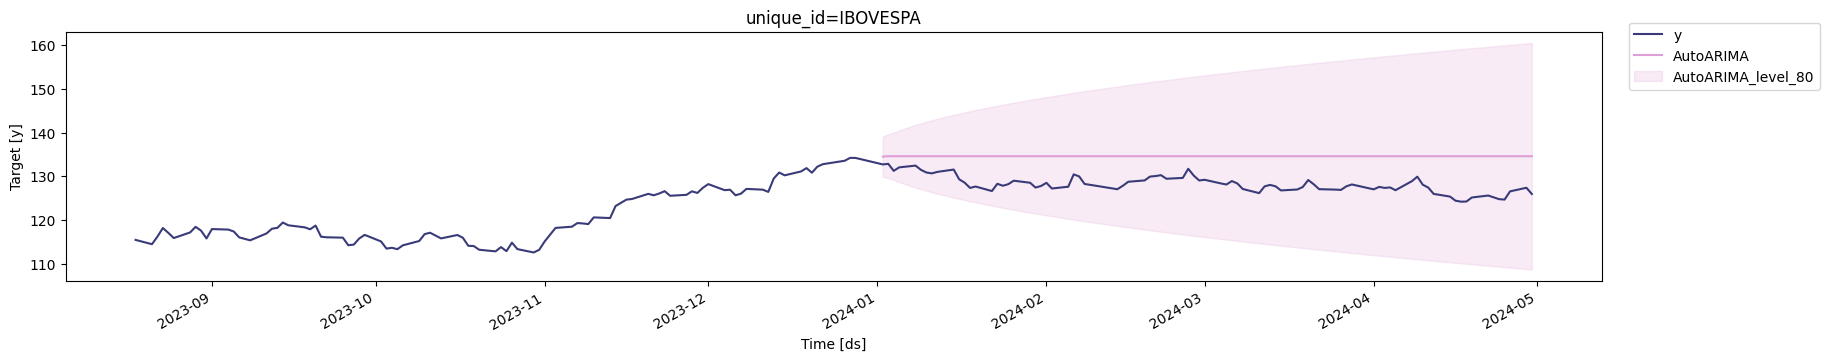

In [404]:
# Ajustando o modelo
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(train)

# Fazendo a previsão
forecast_dfa = model_a.predict(h=h, level=[80])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Removendo valores ausentes
forecast_dfa = forecast_dfa.dropna(subset=['y', 'AutoARIMA'])

# Calculando WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Verificando se a soma dos valores reais é zero
if np.sum(forecast_dfa['y'].values) == 0:
    print("A soma dos valores reais é zero, o que causa divisão por zero no cálculo do WMAPE.")
else:
    wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
    print(f"WMAPE: {wmape4:.2%}")

# Plotando o resultado
model_a.plot(train, forecast_dfa, level=[80], engine='matplotlib', max_insample_length=90)

## Preparando o DataFrame para treino e teste (Prophet)

In [405]:
df_p.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Último_diff,unique_id
1117,2020-01-02,118.573,115.652,118.573,115.649,5160000.0,NaN,IBOVESPA
1116,2020-01-03,117.707,118.564,118.792,117.341,6830000.0,-0.866,IBOVESPA
1115,2020-01-06,116.878,117.707,117.707,116.269,6570000.0,-0.829,IBOVESPA


In [406]:
df_p = df_p[["Data", "Último", "Abertura"]]
df_p.head(3)

,Data,Último,Abertura
1117,2020-01-02,118.573,115.652
1116,2020-01-03,117.707,118.564
1115,2020-01-06,116.878,117.707


In [407]:
df_p = df_p.rename(columns={'Data':'ds','Último':'y','Abertura':'Open'})
df_p.head(3)

,ds,y,Open
1117,2020-01-02,118.573,115.652
1116,2020-01-03,117.707,118.564
1115,2020-01-06,116.878,117.707


In [408]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118 entries, 1117 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1118 non-null   datetime64[ns]
 1   y       1118 non-null   float64       
 2   Open    1118 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 34.9 KB


In [409]:
# Filtrar base de treino entre Jan 2020 até Dez de 2023
train_prophet = df_p.loc[df_p['ds'] < '2024-01-01']

# Filtrar base de teste entre Jan 2024 até Jun de 2024
test_prophet = df_p.loc[(df_p['ds'] >= '2024-01-01') & (df_p['ds'] < '2024-07-01')]

## Modelo Prophet

In [410]:
model_p = Prophet(daily_seasonality=True)
model_p.add_regressor("Open")
model_p.fit(train_prophet)

future = model_p.make_future_dataframe(periods=len(test_prophet))
future["Open"] = pd.concat([train_prophet["Open"], test_prophet["Open"]], ignore_index=True)
forecast_p = model_p.predict(future)

preds = forecast_p[["ds", "yhat"]].tail(len(test_prophet))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp40gf2w3x/pyjmw2i5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp40gf2w3x/f8fr_9u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40135', 'data', 'file=/tmp/tmp40gf2w3x/pyjmw2i5.json', 'init=/tmp/tmp40gf2w3x/f8fr_9u6.json', 'output', 'file=/tmp/tmp40gf2w3x/prophet_modelxm_00xvv/prophet_model-20240730041848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Metrics:
MAE: 1.157679277745846
MSE: 1.9042152233984793
MAPE: 1.6367065649152728


In [411]:
forecast_p.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Open,Open_lower,Open_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,116.704496,112.883043,117.161164,116.704496,116.704496,5.665141,5.665141,5.665141,-1.690895,...,-0.393729,-0.393729,-0.393729,0.382453,0.382453,0.382453,0.0,0.0,0.0,115.013601
1,2020-01-03,116.707155,115.524105,119.951249,116.707155,116.707155,8.492700,8.492700,8.492700,1.097480,...,-0.443648,-0.443648,-0.443648,0.393188,0.393188,0.393188,0.0,0.0,0.0,117.804636
2,2020-01-06,116.715133,114.724024,119.091544,116.715133,116.715133,7.660551,7.660551,7.660551,0.265660,...,-0.466878,-0.466878,-0.466878,0.416746,0.416746,0.416746,0.0,0.0,0.0,116.980792
3,2020-01-07,116.717792,114.201370,118.509773,116.717792,116.717792,6.849764,6.849764,6.849764,-0.270512,...,-0.197015,-0.197015,-0.197015,0.421498,0.421498,0.421498,0.0,0.0,0.0,116.447279
4,2020-01-08,116.720451,113.890329,118.275383,116.720451,116.720451,6.650709,6.650709,6.650709,-0.604331,...,-0.334923,-0.334923,-0.334923,0.424643,0.424643,0.424643,0.0,0.0,0.0,116.116120


## Plotando Previsão vs Real (Prophet)

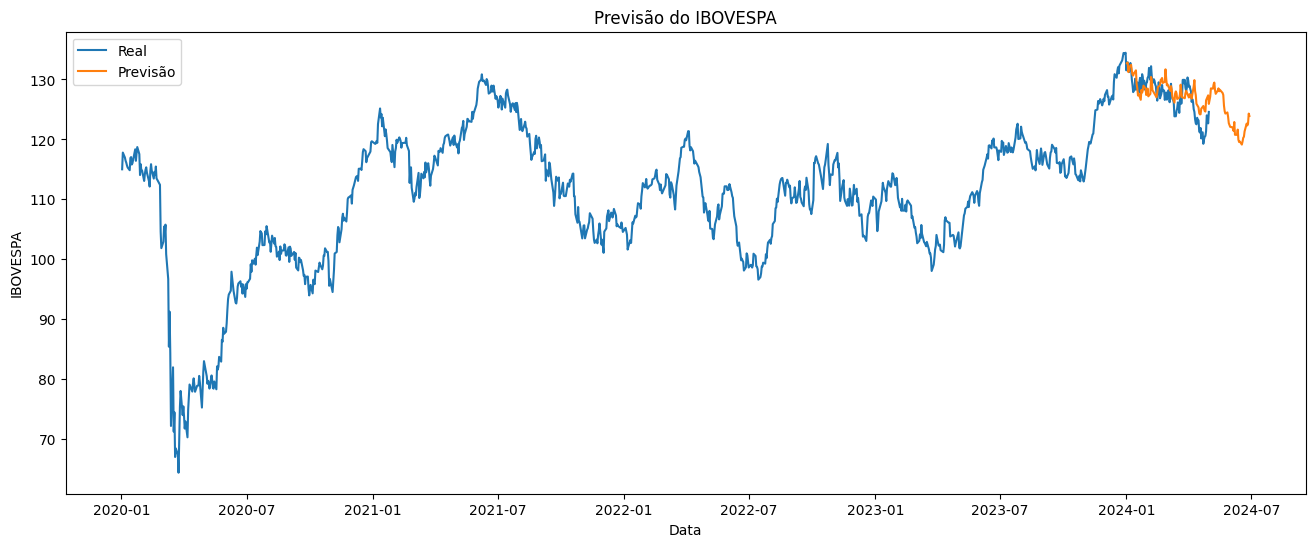

In [413]:
plt.figure(figsize=(16, 6))
#plt.plot(train_prophet['ds'], train_prophet['y'], label='Treino')
plt.plot(forecast_p['ds'], forecast_p['yhat'], label='Real')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Previsão')
plt.xlabel('Data')
plt.ylabel('IBOVESPA')
plt.title('Previsão do IBOVESPA')
plt.legend()
plt.show()

## Interpretação e Conclusão

- **Precisão Geral**: O modelo Prophet está apresentando um desempenho razoavelmente bom. O MAPE abaixo de 2% sugere que o modelo é capaz de prever os valores futuros com uma boa precisão relativa.

- **Erros Absolutos**: Embora o MAE e o MSE indiquem que existem erros absolutos, a magnitude desses erros deve ser comparada à escala dos dados para uma interpretação adequada. Se os valores reais são de uma ordem de grandeza maior, os erros absolutos podem ser considerados pequenos.

- **Desvios Maiores**: O MSE relativamente maior em comparação com o MAE pode indicar a presença de alguns outliers ou grandes desvios nas previsões.